In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
!pip install qiskit-finance
!pip install qiskit-algorithms
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.1 MB/s eta 0:00:00


In [21]:
# Core Qiskit and Aer Simulator
from qiskit import transpile
from qiskit_aer import Aer
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator

# Algorithms (latest)
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem, VQE
from qiskit_algorithms.optimizers import COBYLA

# Circuit components
from qiskit.circuit.library import TwoLocal
from qiskit_finance.circuit.library import NormalDistribution

# Primitives and operators
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, Sampler

# Utilities (latest location)
from qiskit_algorithms.utils import algorithm_globals


In [5]:
import pandas as pd

# Load the dataset (use your uploaded file path or upload manually in Colab)
df = pd.read_csv('/content/commercial-credit-exposure-by-counterparty-rating.csv')

# Display basic structure
print("Shape:", df.shape)
df.head()


Shape: (110, 5)


,Organization,Period End Date,Category,Counterparty Rating,"Amount (US$, millions)"
0,IBRD,2010-06-30T00:00:00.000,"Agencies, ABS, Corporates and Time Deposites",BB,7
1,IBRD,2010-06-30T00:00:00.000,"Agencies, ABS, Corporates and Time Deposites",AA,10039
2,IBRD,2010-06-30T00:00:00.000,"Agencies, ABS, Corporates and Time Deposites",AAA,6160
3,IBRD,2010-06-30T00:00:00.000,"Agencies, ABS, Corporates and Time Deposites",BBB,4
4,IBRD,2010-06-30T00:00:00.000,"Agencies, ABS, Corporates and Time Deposites",A,4944


In [6]:
# Standardize column names
df.columns = [col.strip().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]

# Convert date to datetime
df['Period_End_Date'] = pd.to_datetime(df['Period_End_Date'])

# Check for missing values
print(df.isnull().sum())

# Drop duplicates (if any)
df.drop_duplicates(inplace=True)


Organization            0
Period_End_Date         0
Category                0
Counterparty_Rating     0
Amount_US$,_millions    0
dtype: int64


In [7]:
df.rename(columns={'Amount_US$,_millions': 'Amount'}, inplace=True)


In [8]:
# Map credit rating to PD
rating_to_pd = {
    'AAA': 0.0002, 'AA': 0.0005, 'A': 0.001,
    'BBB': 0.005, 'BB': 0.02, 'B': 0.05,
    'CCC': 0.2, 'CC': 0.3, 'C': 0.4, 'D': 1.0
}
df['PD'] = df['Counterparty_Rating'].map(rating_to_pd)

# Drop rows where PD couldn't be assigned
df.dropna(subset=['PD'], inplace=True)

# Feature Engineering
df['RWE'] = df['Amount'] * df['PD']

# Funding cost proxy (based on category)
funding_rate = {
    'Banks': 0.01,
    'Sovereigns': 0.005,
    'Corporates': 0.015,
    'Other Financial Institutions': 0.02,
    'Others': 0.01
}
df['Funding_Cost'] = df.apply(lambda x: x['Amount'] * funding_rate.get(x['Category'], 0.01), axis=1)

# Capital charge (8% of RWE)
df['Capital_Charge'] = df['RWE'] * 0.08

# Final dataframe
df_model = df[['Counterparty_Rating', 'Category', 'Amount', 'PD', 'RWE', 'Funding_Cost', 'Capital_Charge']]
df_model.head()


,Counterparty_Rating,Category,Amount,PD,RWE,Funding_Cost,Capital_Charge
0,BB,"Agencies, ABS, Corporates and Time Deposites",7,0.0200,0.1400,0.07,0.01120
1,AA,"Agencies, ABS, Corporates and Time Deposites",10039,0.0005,5.0195,100.39,0.40156
2,AAA,"Agencies, ABS, Corporates and Time Deposites",6160,0.0002,1.2320,61.60,0.09856
3,BBB,"Agencies, ABS, Corporates and Time Deposites",4,0.0050,0.0200,0.04,0.00160
4,A,"Agencies, ABS, Corporates and Time Deposites",4944,0.0010,4.9440,49.44,0.39552


In [9]:
# Basic descriptive stats
df_model.describe(include='all')

,Counterparty_Rating,Category,Amount,PD,RWE,Funding_Cost,Capital_Charge
count,96,96,96.000000,96.000000,96.000000,96.000000,96.000000
unique,7,5,NaN,NaN,NaN,NaN,NaN
top,AA,Sovereigns,NaN,NaN,NaN,NaN,NaN
freq,30,36,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4316.927083,0.004031,1.890136,32.023698,0.151211
std,NaN,NaN,4230.438077,0.021033,1.830295,31.361403,0.146424
min,NaN,NaN,1.000000,0.000200,0.010000,0.010000,0.000800
25%,NaN,NaN,430.500000,0.000200,0.288500,2.340000,0.023080
50%,NaN,NaN,3482.000000,0.000500,1.561500,26.430000,0.124920
75%,NaN,NaN,7392.250000,0.001000,2.623900,49.260000,0.209912


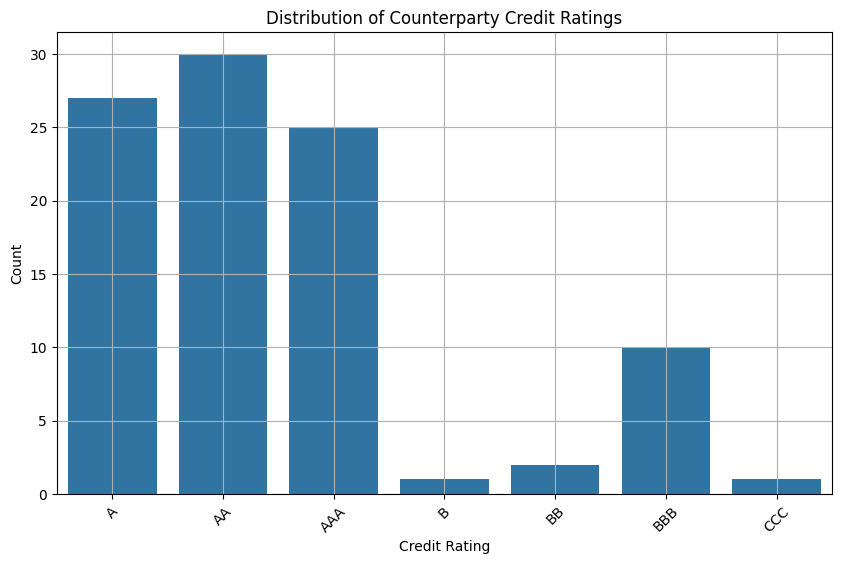

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df_model, x='Counterparty_Rating', order=sorted(df_model['Counterparty_Rating'].unique()))
plt.title("Distribution of Counterparty Credit Ratings")
plt.xlabel("Credit Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

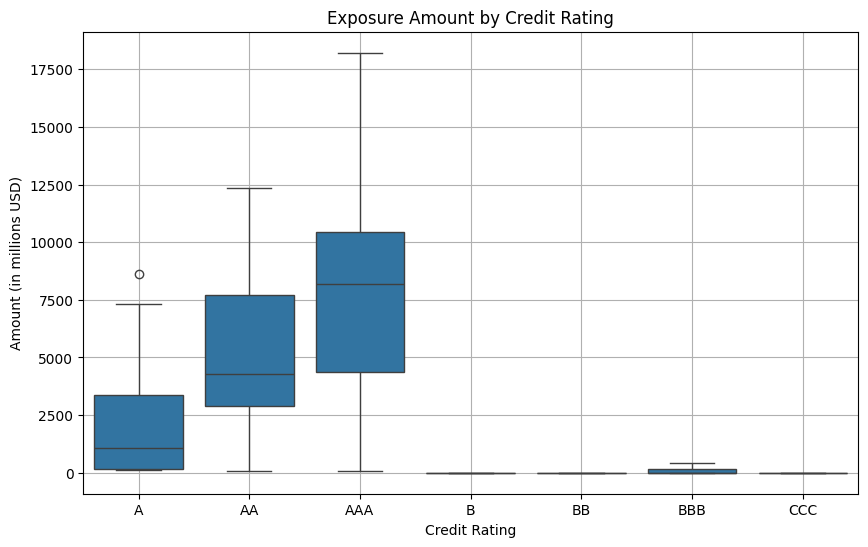

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_model, x='Counterparty_Rating', y='Amount', order=sorted(df_model['Counterparty_Rating'].unique()))
plt.title("Exposure Amount by Credit Rating")
plt.xlabel("Credit Rating")
plt.ylabel("Amount (in millions USD)")
plt.grid(True)
plt.show()

<ipython-input-12-fed89c4c0099>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rwe_by_category.index, y=rwe_by_category.values, palette="viridis")


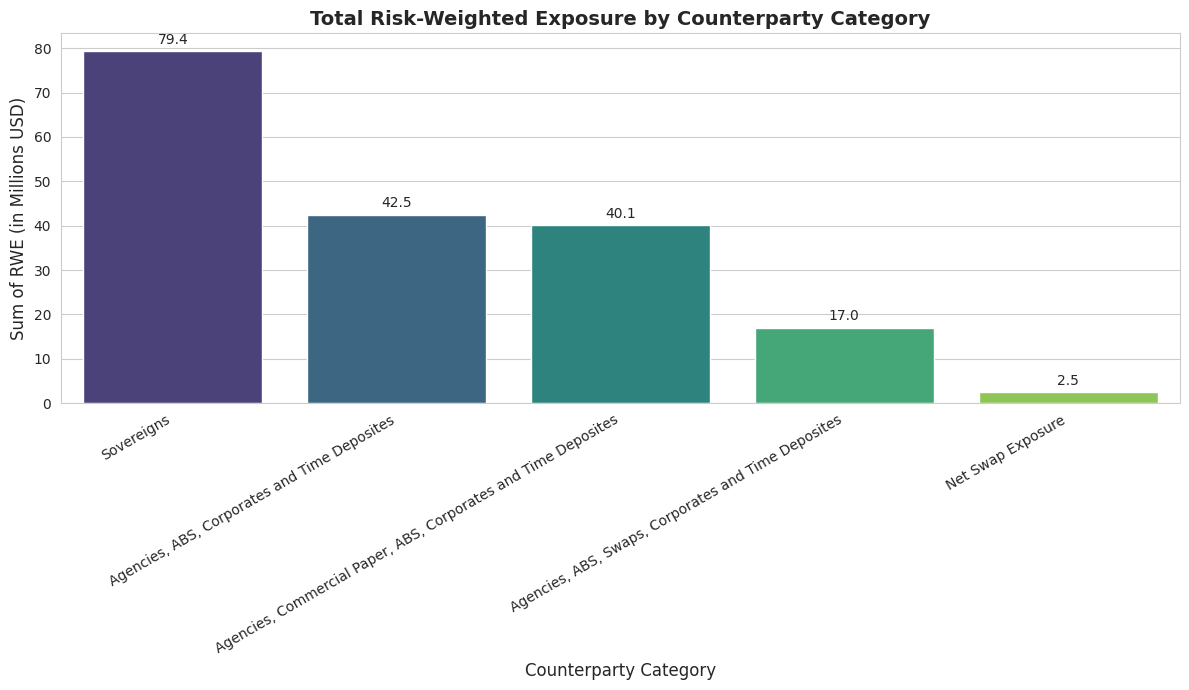

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and sort RWE by Category
rwe_by_category = df_model.groupby('Category')['RWE'].sum().sort_values(ascending=False)

# Set figure size and style
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create bar plot with clean labels
ax = sns.barplot(x=rwe_by_category.index, y=rwe_by_category.values, palette="viridis")

# Add value labels on top
for i, val in enumerate(rwe_by_category.values):
    ax.text(i, val + 1, f'{val:.1f}', ha='center', va='bottom', fontsize=10)

# Labeling
plt.title("Total Risk-Weighted Exposure by Counterparty Category", fontsize=14, weight='bold')
plt.xlabel("Counterparty Category", fontsize=12)
plt.ylabel("Sum of RWE (in Millions USD)", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


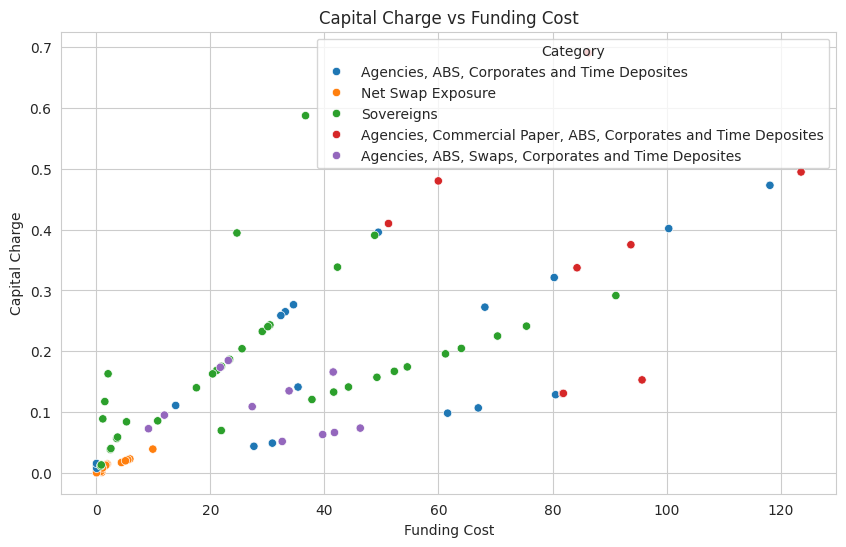

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_model, x='Funding_Cost', y='Capital_Charge', hue='Category')
plt.title("Capital Charge vs Funding Cost")
plt.xlabel("Funding Cost")
plt.ylabel("Capital Charge")
plt.grid(True)
plt.show()


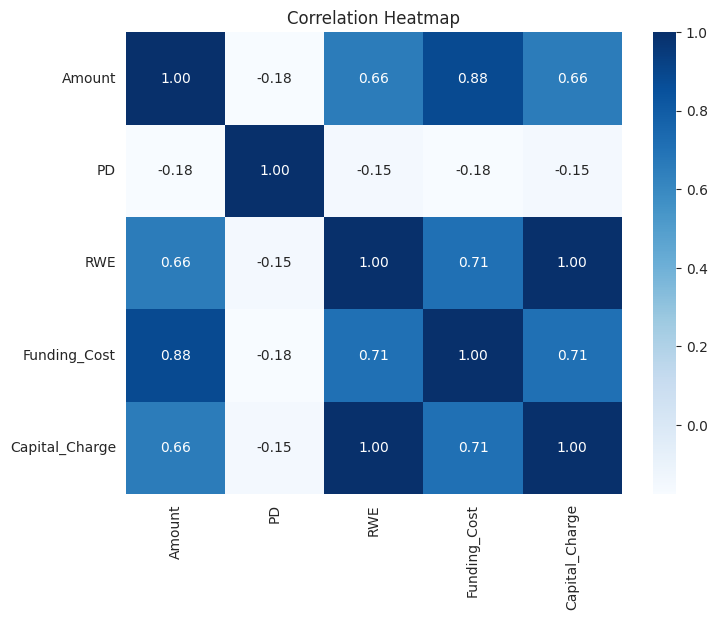

In [14]:
plt.figure(figsize=(8, 6))
corr_matrix = df_model[['Amount', 'PD', 'RWE', 'Funding_Cost', 'Capital_Charge']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [16]:
df_model.loc[:, 'Default_Risk'] = df_model['PD'].apply(lambda x: 1 if x > 0.01 else 0)
print(df_model['Default_Risk'].value_counts())


Default_Risk
0    92
1     4
Name: count, dtype: int64


<ipython-input-16-387b82298499>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, 'Default_Risk'] = df_model['PD'].apply(lambda x: 1 if x > 0.01 else 0)


In [17]:
from imblearn.over_sampling import RandomOverSampler

# Split with stratify to preserve class balance
X = df_model[['Amount', 'RWE', 'Funding_Cost', 'Capital_Charge']]
y = df_model['Default_Risk']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply RandomOverSampler instead of SMOTE
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


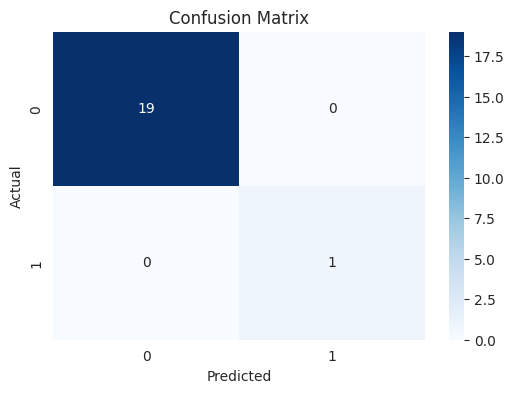

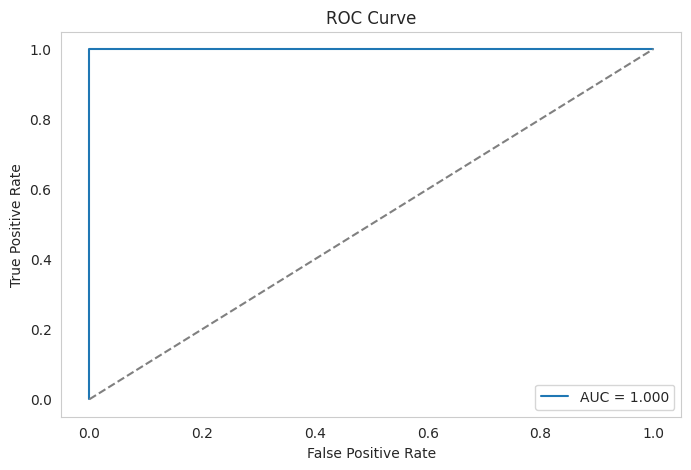

In [29]:
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, accuracy_score

# Features + Target (already created above)
X = df_model[['Amount', 'Rating_Encoded', 'Category_Encoded', 'RWE', 'Funding_Cost', 'Capital_Charge']]
y = df_model['Default_Risk']

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Train the model
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_resampled, y_resampled)

# Evaluate (optional)
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


Estimated amplitude (probability of default): 0.1464


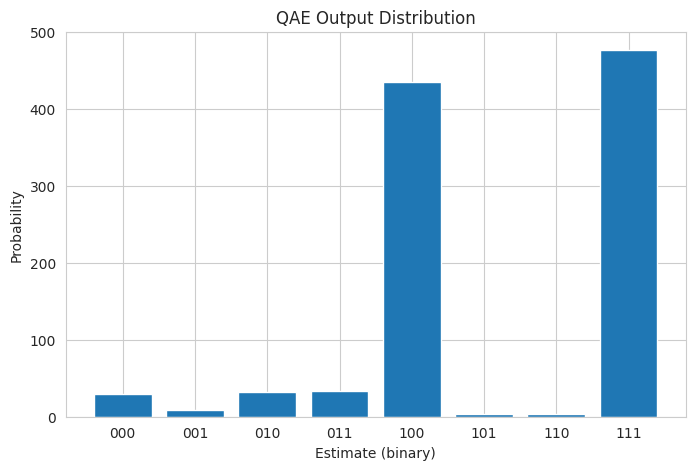

In [30]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister
from qiskit_algorithms import EstimationProblem, AmplitudeEstimation
from qiskit_aer.primitives import Sampler
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42

# Step 1: Build a simple state prep circuit to simulate amplitude (e.g., default risk ~ 0.2)
qr = QuantumRegister(1)
state_preparation = QuantumCircuit(qr)
state_preparation.ry(2 * np.arcsin(np.sqrt(0.2)), qr[0])  # Prepares amplitude sqrt(0.2)

# Step 2: Define estimation problem
problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[0]
)

# Step 3: Run QAE
ae = AmplitudeEstimation(num_eval_qubits=3, sampler=Sampler())
result = ae.estimate(problem)

# Step 4: Display result
print(f"\nEstimated amplitude (probability of default): {result.estimation:.4f}")

# Plot histogram
# Extract probabilities for each estimate
labels = list(result.circuit_results.keys())
probs = list(result.circuit_results.values())

# Convert labels from binary strings to decimals
labels_dec = [int(k, 2) for k in labels]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.bar(labels_dec, probs, tick_label=labels)
plt.title("QAE Output Distribution")
plt.xlabel("Estimate (binary)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


In [25]:
from sklearn.preprocessing import LabelEncoder

# Encode 'Counterparty_Rating' and 'Category'
df_model['Rating_Encoded'] = LabelEncoder().fit_transform(df_model['Counterparty_Rating'])
df_model['Category_Encoded'] = LabelEncoder().fit_transform(df_model['Category'])


Model Comparison:
                  Model  Estimated PD
0  True PD (Simulated)      0.200000
1         XGBoost (AI)      0.075056
2        QAE (Quantum)      0.146400


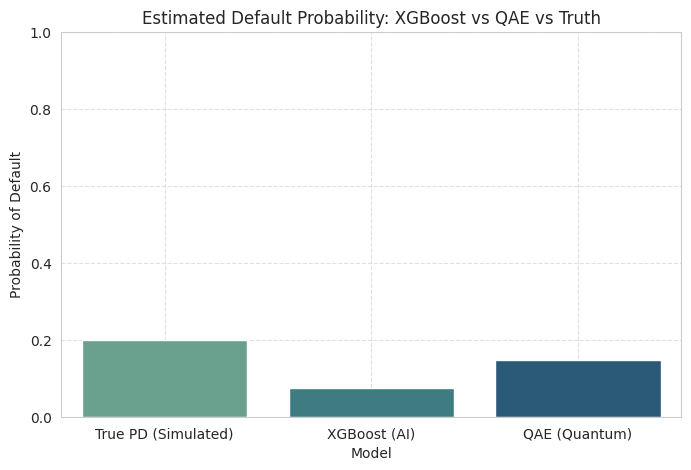

In [31]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated True PD (used in QAE circuit setup)
true_pd = 0.20

# QAE estimated result (your output)
qae_pd = 0.1464

# Rebuild the test set with full feature set used in training
feature_cols = ['Amount', 'Rating_Encoded', 'Category_Encoded', 'RWE', 'Funding_Cost', 'Capital_Charge']
target_col = 'Default_Risk'

X = df_model[feature_cols]
y = df_model[target_col]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Get XGBoost predicted probabilities for class 1 (default)
xgb_pd_preds = xgb_model.predict_proba(X_test)[:, 1]
xgb_avg_pd = xgb_pd_preds.mean()

# Build comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['True PD (Simulated)', 'XGBoost (AI)', 'QAE (Quantum)'],
    'Estimated PD': [true_pd, xgb_avg_pd, qae_pd]
})

# Print and Plot
print("\nModel Comparison:\n", comparison_df)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Estimated PD', data=comparison_df, hue='Model', dodge=False, palette='crest', legend=False)
plt.title("Estimated Default Probability: XGBoost vs QAE vs Truth")
plt.ylim(0, 1)
plt.ylabel("Probability of Default")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [53]:
# Imports
import numpy as np
import pandas as pd
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Estimator as AerEstimator

#  Load and preprocess dataset
df = pd.read_csv("commercial-credit-exposure-by-counterparty-rating.csv")
df.rename(columns={"Amount (US$, millions)": "Amount"}, inplace=True)

# Map ratings to PD
df['PD'] = df['Counterparty Rating'].map({
    'AAA': 0.0002, 'AA': 0.0005, 'A': 0.001,
    'BBB': 0.005, 'BB': 0.02, 'B': 0.05,
    'CCC': 0.2, 'CC': 0.3, 'C': 0.4, 'D': 1.0
})
df.dropna(subset=['PD'], inplace=True)
df['Amount'] = df['Amount'].astype(float)
df['RWE'] = df['Amount'] * df['PD']
df['Funding_Cost'] = df['Amount'] * 0.01
df['Capital_Charge'] = df['RWE'] * 0.08

# Select top 4 counterparties by Capital_Charge
df_model = df[['Counterparty Rating', 'Category', 'Amount', 'PD', 'RWE', 'Funding_Cost', 'Capital_Charge']]
top_counterparties = df_model.sort_values(by="Capital_Charge", ascending=False).head(4).reset_index(drop=True)

# Normalize capital charges for Z-weights
z_weights = (top_counterparties["Capital_Charge"] / top_counterparties["Capital_Charge"].max()).round(2).tolist()

#  Define ZZ interaction weights
zz_weights = [0.1, 0.05, 0.02]  # Simulated correlation/risk spread

# Build 4-qubit Hamiltonian
pauli_list = []
for i, weight in enumerate(z_weights):
    pauli_str = ['I'] * 4
    pauli_str[i] = 'Z'
    pauli_list.append(("".join(pauli_str), float(weight)))

zz_pairs = [(0,1), (1,2), (2,3)]
for (i,j), weight in zip(zz_pairs, zz_weights):
    pauli_str = ['I'] * 4
    pauli_str[i] = 'Z'
    pauli_str[j] = 'Z'
    pauli_list.append(("".join(pauli_str), float(weight)))

hamiltonian_4q = SparsePauliOp.from_list(pauli_list)

# VQE Setup
ansatz = TwoLocal(num_qubits=4, reps=1, rotation_blocks='ry', entanglement_blocks='cz', entanglement='full')
estimator = AerEstimator()
optimizer = COBYLA(maxiter=150)

vqe = VQE(ansatz=ansatz, optimizer=optimizer, estimator=estimator)

# Run VQE
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_4q)

# Output result
print(f"Optimized 4-Qubit Capital Cost (VQE Energy): {vqe_result.eigenvalue.real:.4f}")


Optimized 4-Qubit Capital Cost (VQE Energy): -3.0299


<ipython-input-54-88dfb55ed6d5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=z_weights_plot.index, y=z_weights_plot.values, ax=axs[0], palette="crest")
<ipython-input-54-88dfb55ed6d5>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zz_weights_plot.index, y=zz_weights_plot.values, ax=axs[1], palette="flare")


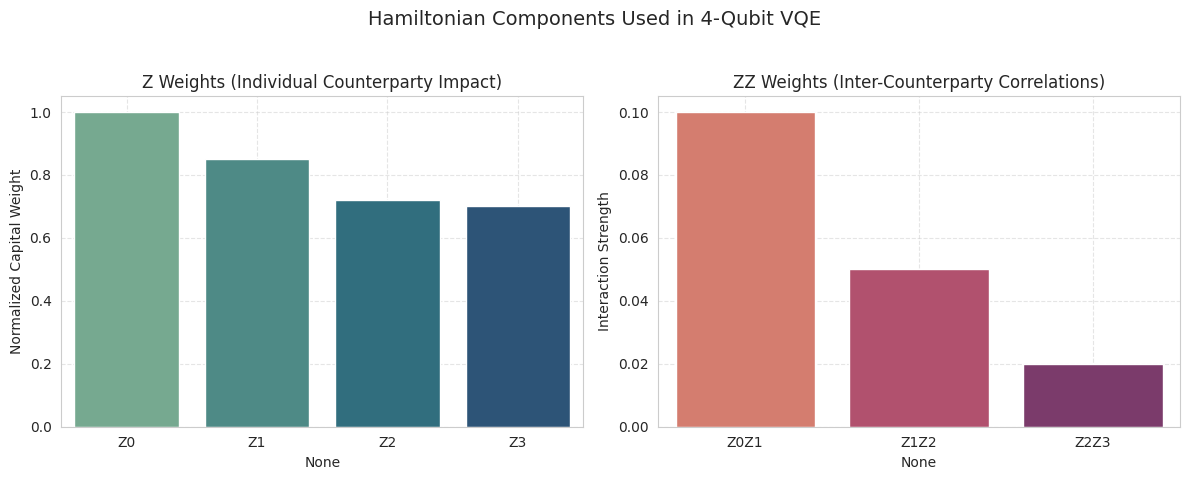

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data: weights used in the 4-qubit VQE simulation
z_weights_plot = pd.Series(z_weights, index=[f"Z{i}" for i in range(4)])
zz_weights_plot = pd.Series(zz_weights, index=[f"Z{i}Z{i+1}" for i in range(3)])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Z weights
sns.barplot(x=z_weights_plot.index, y=z_weights_plot.values, ax=axs[0], palette="crest")
axs[0].set_title("Z Weights (Individual Counterparty Impact)")
axs[0].set_ylabel("Normalized Capital Weight")
axs[0].grid(True, linestyle='--', alpha=0.5)

# Plot ZZ weights
sns.barplot(x=zz_weights_plot.index, y=zz_weights_plot.values, ax=axs[1], palette="flare")
axs[1].set_title("ZZ Weights (Inter-Counterparty Correlations)")
axs[1].set_ylabel("Interaction Strength")
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Hamiltonian Components Used in 4-Qubit VQE", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [50]:
import time

# Measure classical brute-force energy (for benchmarking)
z_vals = [-1, 1]
start_classical = time.time()
min_energy_classical = min([
    z_weights[0]*z0 + z_weights[1]*z1 + z_weights[2]*z2 + z_weights[3]*z3 +
    zz_weights[0]*z0*z1 + zz_weights[1]*z1*z2 + zz_weights[2]*z2*z3
    for z0 in z_vals for z1 in z_vals for z2 in z_vals for z3 in z_vals
])
end_classical = time.time()
time_classical = end_classical - start_classical

# Measure quantum (VQE) runtime
start_quantum = time.time()
vqe_result_4q = vqe.compute_minimum_eigenvalue(operator=hamiltonian_4q)
end_quantum = time.time()
time_quantum = end_quantum - start_quantum

{
    "Classical Min Energy": round(min_energy_classical, 4),
    "VQE Energy": round(vqe_result_4q.eigenvalue.real, 4),
    "Classical Time (s)": round(time_classical, 4),
    "VQE Time (s)": round(time_quantum, 4)
}


{'Classical Min Energy': -3.1,
 'VQE Energy': np.float64(-3.0637),
 'Classical Time (s)': 0.0002,
 'VQE Time (s)': 0.4894}

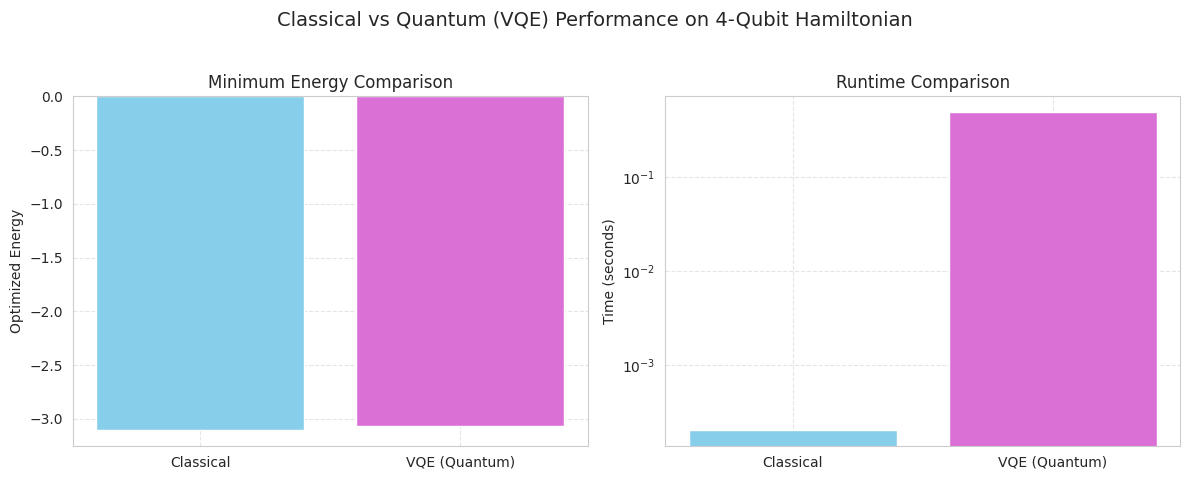

In [52]:
import matplotlib.pyplot as plt

# Data for comparison plot
models = ['Classical', 'VQE (Quantum)']
energies = [-3.1, -3.0637]
runtimes = [0.0002, 0.4894]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Energy Comparison
axs[0].bar(models, energies, color=['skyblue', 'orchid'])
axs[0].set_title("Minimum Energy Comparison")
axs[0].set_ylabel("Optimized Energy")
axs[0].grid(True, linestyle='--', alpha=0.5)

# Runtime Comparison
axs[1].bar(models, runtimes, color=['skyblue', 'orchid'])
axs[1].set_title("Runtime Comparison")
axs[1].set_ylabel("Time (seconds)")
axs[1].set_yscale('log')  # log scale to show big gap clearly
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Classical vs Quantum (VQE) Performance on 4-Qubit Hamiltonian", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [55]:
# Perform risk sensitivity analysis by varying Z weights (stress testing individual counterparty impact)
z_range = [0.2, 0.4, 0.6, 0.8, 1.0]
sensitivity_results = []

# Keep ZZ weights constant for now
zz_weights_fixed = [0.1, 0.05, 0.02]

for z_val in z_range:
    # Apply the same stress level to all Z terms for simplicity
    z_weights_test = [z_val] * 4

    # Create new Pauli list for this configuration
    pauli_list_stress = []
    for i, weight in enumerate(z_weights_test):
        pauli_str = ['I'] * 4
        pauli_str[i] = 'Z'
        pauli_list_stress.append(("".join(pauli_str), float(weight)))

    zz_pairs = [(0, 1), (1, 2), (2, 3)]
    for (i, j), weight in zip(zz_pairs, zz_weights_fixed):
        pauli_str = ['I'] * 4
        pauli_str[i] = 'Z'
        pauli_str[j] = 'Z'
        pauli_list_stress.append(("".join(pauli_str), float(weight)))

    # Create Hamiltonian and run VQE
    hamiltonian_stress = SparsePauliOp.from_list(pauli_list_stress)
    vqe_result_stress = vqe.compute_minimum_eigenvalue(operator=hamiltonian_stress)

    # Store result
    sensitivity_results.append({
        'Z_Weight': z_val,
        'VQE_Energy': vqe_result_stress.eigenvalue.real
    })

# Convert to DataFrame for plotting
df_sensitivity = pd.DataFrame(sensitivity_results)
df_sensitivity


,Z_Weight,VQE_Energy
0,0.2,-0.629023
1,0.4,-1.429355
2,0.6,-2.203691
3,0.8,-3.010723
4,1.0,-3.830000


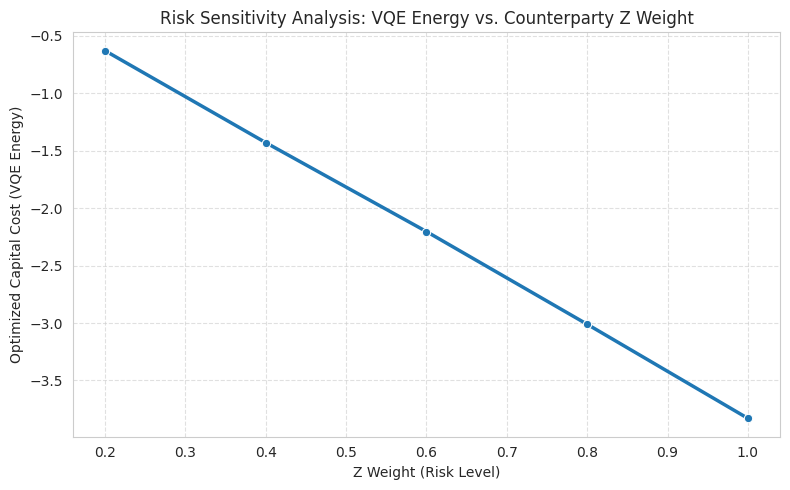

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Risk Sensitivity Analysis Results
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_sensitivity, x='Z_Weight', y='VQE_Energy', marker='o', linewidth=2.5)
plt.title("Risk Sensitivity Analysis: VQE Energy vs. Counterparty Z Weight")
plt.xlabel("Z Weight (Risk Level)")
plt.ylabel("Optimized Capital Cost (VQE Energy)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
